<a href="https://colab.research.google.com/github/anthonymelson/portfolio/blob/master/Bayesian_Estimation_of_Difference_in_Success_Rate_Between_Two_Groups_on_Binary_Task_Using_Pymc3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bayesian Estimation of Difference in Success Rate Between Two Groups on Binary Task Using Pymc3

This notebook is meant to be a gentle intro to Bayesian Estimation.  The goal is *not* to claim that Bayesian Estimation is superior to frequentist hypothesis testing, but rather to highlight some of its appealing characteristics and show how it can be implemented in Pymc3.



### Motivation

Bayesian Estimation is used in many areas of science and industry.  When contrasted with frequentist approaches to estimating group differences (i.e. null hypothesis testing), benefits *can* include: 
* clearer output (distribution of probabilities, instead of p-vals and confidence intervals)
* increased flexibility (small N, uneven groups, unequal var...)
* encoding/utilization of prior understanding (domain expertise, previous research...) into the prior (conjugate) distributions.

This list is by no means comprehensive, but should provide those unfamiliar to Bayesian Estimation a sense of why it is worthy of investigation and usage in addition to null hypothesis testing.

## Problem Discussion and Model Specification

### Problem Discussion

*Problem*: A scientist is about to observe two groups (a and b) repeatedly flipping two *potentially* differently wieghted coins (a and b) a *potentially* unequal number of times.  The scientist must decide: 1) whether the coins are fairly matched, and if they are not 2) estimate the difference in thier likelihood of suceeding (landing heads).


### Model Specification

In the following, a model will be specified as two Bernoulli Random Variables (one for each arm of the experiment) with TruncatedNormal Distributions as priors for their probability parameter (p).  Next, the posterior distributions (probability of probabilities of success) for each arm will be inferred using MCMC, and the difference between the two resultant distributions will be taken to get Delta_P (probability of a range differences in probability of success between the two groups).

It should be noted that TruncatedNormal Distributions were chosen as priors instead of the Beta Distribution (which is the conjugate prior for Bernoulli Distribution) because they better represented the prior beliefs of the author.  The author reasoned that even loaded coins are not likely to be too far from center since thier general shape (and the physics that govern that shape) would not allow for extreme bias.  Additional wieght was given to the idea that coins that are too loaded or have the same symbol on each side wouldn't serve the function of deception that thier designers presumably intend them to serve.  Both prior beliefs were easier to encode into the std parameter of a TruncatedNormal Distribution than any of the parameters in the Beta Distribution.

## Solution

### Import Packages

In [9]:
import arviz as az
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Create Data



In [10]:
a_s, b_s = 0.6, 0.5

a = np.random.choice(a=[1,0],size=50,p=[a_s,1-a_s])
b = np.random.choice(a=[1,0],size=40,p=[b_s,1-b_s])

print('Observed Means: A:', a.mean(),' B: ', b.mean(), 'Delta: ', abs(b.mean()-a.mean()))
print('True Means: A:', a_s,' B: ', b_s, 'Delta: ', abs(b_s - a_s))

Observed Means: A: 0.68  B:  0.525 Delta:  0.15500000000000003
True Means: A: 0.6  B:  0.5 Delta:  0.09999999999999998


### Model Initialization and Considerations

The TruncatedNormal distribution is being used for several reasons.  

First, it will cover the entire probability space (0-1), without going outside of it.  Since the Normal distribution is unbounded, it continues indefinately approaching 0 as it approaches infinity, unless it is bounded specifically (truncation).  

Second they allow for mu = 0.5, which is a good assumption when prior knowlegde about *specific coins*  is unavailable.  In that case, it is easy to encode the fact that almost all coins in the world have mu = ~ 0.5.  

Third, and **most importantly**, their shape naturally encodes the increased likelihood of a loaded coin being closer to the center of the probability space (0.5) than to the edge of the probability space, near 1 or 0.  

To capture the authors previously stated priors, the mean of the prior TruncatedNormal distributions will be set to zero and the standard deviation will be set to 0.15, meaning the edges of the proability space (0,1) are several standard deviations out from the mean.  Though it is possible for a coin-shaped object to be loaded enough to be improbable in the selected distribution, the authors think the likelihood is negligable. 

In [21]:
# convert input data to numpy arrays
a = np.asarray(a)
b = np.asarray(b)
with pm.Model() as model:

  # Create priors for bernoulli distributions
  mu_a, mu_b, sigma_a, sigma_b = 0.5, 0.5, 0.15, 0.15

  p_a = pm.TruncatedNormal('p_a', mu=mu_a, sigma=sigma_a, lower=0, upper=1)
  p_b = pm.TruncatedNormal('p_b', mu=mu_b, sigma=sigma_b, lower=0, upper=1)

  # Bernoulli random variables with priors AND observed data for both groups
  a_obs = pm.Bernoulli('a_obs', p=p_a, observed=a)
  b_obs = pm.Bernoulli('b_obs', p=p_b, observed=b)

  # Take difference between posteriors to get Delta_p
  delta = pm.Deterministic('delta', p_a - p_b)

  # Sample from the previously defined model
  trace = pm.sample(1000, return_inferencedata=True)

  # Use sample to estimate posterior distributions for both experimental arms
  a_posterior = trace.posterior['p_a'].values
  b_posterior = trace.posterior['p_b'].values

  delta_posterior = trace.posterior['delta'].values

  # Find probability that the success probability is higher in arm a than b
  prob_a_over_b = (a_posterior[0] > b_posterior[0]).mean()


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [p_b, p_a]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 3 seconds.


## Results Summary and Visualization

### Summary of Model Variables & Probability of Difference

Below the mean, standard deviation, and credible intervals of the normal posteriors (for the parameters p in the two Bernoulli Distributions) are shown along with thier deltas (focus of the test).

Next, the probability of a difference in success probabilities is shown for the cases where a > b and b > a.

In [22]:
az.summary(trace, kind='stats')

,mean,sd,hdi_3%,hdi_97%
p_a,0.646,0.061,0.536,0.766
p_b,0.519,0.068,0.400,0.646
delta,0.127,0.090,-0.041,0.291


In [23]:
print('Observed Means: A:', a.mean(),' B: ', b.mean(), 'Delta: ', abs(b.mean()-a.mean()))
print('True Means: A:', a_s,' B: ', b_s, 'Delta: ', abs(b_s - a_s))

Observed Means: A: 0.68  B:  0.525 Delta:  0.15500000000000003
True Means: A: 0.6  B:  0.5 Delta:  0.09999999999999998


In [24]:
print('P(P_success(a) > P_success(b)): ', prob_a_over_b)
print('P(P_success(b) > P_success(a)): ', 1 - prob_a_over_b)

P(P_success(a) > P_success(b)):  0.914
P(P_success(b) > P_success(a)):  0.08599999999999997


### View Posterior Distributions

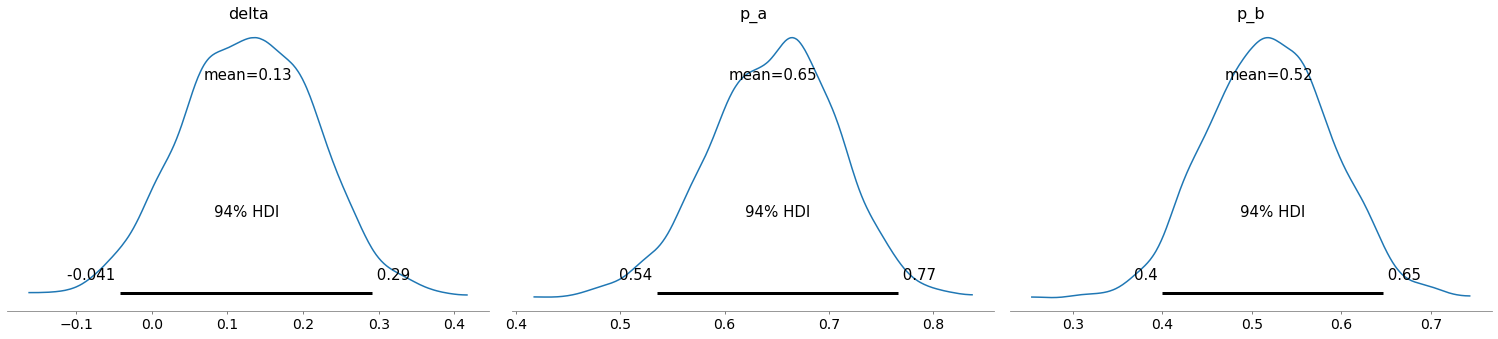

In [25]:
az.plot_posterior(trace, ['delta', 'p_a', 'p_b'])
plt.show()

### A Second View of Posteriors

These visualizations better reveal the overlap and difference between the two posteriors.  Additionally, plotting the two together gives a clearer read of thier comparative variability, which is interpretable as certainty/reliability.

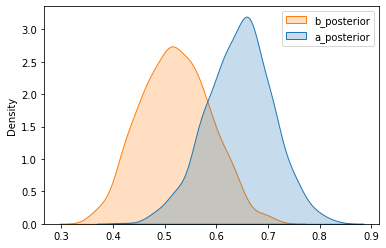

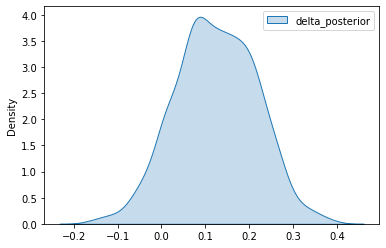

In [26]:
kde = sns.kdeplot(data=[a_posterior[0],b_posterior[0]], fill=True)
kde.legend(labels=['b_posterior','a_posterior'])
plt.show()
delta_kde = sns.kdeplot(data=delta_posterior[0], fill=True)
delta_kde.legend(labels=['delta_posterior'])
#delta_kde.vlines([delta_post.mean()], ymin=0,ymax=10)
plt.show()

## Conclusion

The fitted model determined that there is a >91% probability that Group A has a higher success rate than Group B, which is a correct directional read given thier true wieghts (0.6 and 0.5 respectively).  In addition to the directional read, the predicted delta was ~ 0.127, which is closer to that of the data generating process (0.1) than the observed data (~ 0.155).  

Additionally, it is worth noting that the posterior distributions had more accurate estimates of the underlining data generation process than the observed quantities (both of which were high).